## Wheat Models: 

In [322]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error, r2_score

from xgboost import plot_tree
import matplotlib.pyplot as plt
import graphviz

import numpy as np
from functools import partial
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

from IPython.display import clear_output

#### Train test split

In [323]:
table  = pd.read_csv('modeling_table.csv')

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(table["country"])
table["country_encoded"]= le.transform(table["country"])

#table["country"] = table["country"].astype("category")

X = table.drop(['target', 'country'],axis=1)
y = table['target']

X_train,X_test, y_train, y_test = train_test_split(X,y,random_state =0, test_size=0.25)

In [324]:
len(table)

1204

#### Decision tree regressor:

In [325]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [326]:
m = dt_model
pred_train = m.predict(X_train)
tr_rmse = mean_squared_error(y_train, pred_train)

predictions = m.predict(X_test)
ts_rmse = mean_squared_error(y_test, predictions)

y_mean= [table["target"].mean()] * len(y_test)
me = mean_squared_error(y_test, y_mean)

print("train rmse: ",tr_rmse)
print("test rmse: ",ts_rmse)
print("mean rmse: ",me)

train rmse:  0.0
test rmse:  1.6474693804306317
mean rmse:  3.7825209932321147


#### XGboost model

In [327]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

/Users/rajkal/opt/anaconda3/envs/boost_39/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [329]:
m = xgb_model
pred_train = m.predict(X_train)
tr_rmse = mean_squared_error(y_train, pred_train)

predictions = m.predict(X_test)
ts_rmse = mean_squared_error(y_test, predictions)

y_mean= [table["target"].mean()] * len(y_test)
me = mean_squared_error(y_test, y_mean)

print("train rmse: ",tr_rmse)
print("test rmse: ",ts_rmse)
print("mean rmse: ",me)

train rmse:  3.5112596313621154e-05
test rmse:  1.0162287831972838
mean rmse:  3.7825209932321147


/Users/rajkal/opt/anaconda3/envs/boost_39/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



#### XGboost hyperopt

In [333]:
def objective(space, data, optimizer_metrics):
    X_train, _, y_train, _ = data
    data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)
    xgb_cv = xgb.cv(dtrain=data_dmatrix, params=space, nfold=5, metrics=optimizer_metrics) 
    metric = 'test-mae-mean' if optimizer_metrics == 'mae' else 'test-rmse-mean'
    score = np.min(xgb_cv[metric])  # ez lehet, hogy nem lesz jó, mert a metric név nem tuti, csekkold le külön, hogy mi lesz az xgb.cv kimentében!
    return {'loss': score, 'status': STATUS_OK}

In [334]:
space = {
    'booster': 'gbtree',
    'max_depth': hp.choice('max_depth', np.arange(5, 12, 1, dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(700, 2000, 100, dtype=int)),
    'learning_rate': hp.quniform('learning_rate', 0.05, 0.25, 0.05), 
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
    'colsample_bynode' : hp.quniform('colsample_bynode', 0.5,0.9, 0.1),   
    'colsample_bylevel' : hp.quniform('colsample_bylevel', 0.5,0.9, 0.1),   
    'min_child_weight': hp.choice('min_child_weight', np.arange(4, 12, 1, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 0.9, 0.1),
    'eta': hp.quniform('eta', 0.1, 0.3, 0.1),
    'eval_metric': 'rmse',
    'seed': 42,
    'random_state': 42
}

In [335]:
fmin_objective = partial(objective, data=(X_train,X_test, y_train, y_test), optimizer_metrics='rmse') 
best_hyper = fmin(fn=fmin_objective,
                  space=space,
                  algo=tpe.suggest,
                  max_evals=60,
                  trials=Trials())

best = space_eval(space, best_hyper)
clear_output()

In [336]:
best

{'booster': 'gbtree',
 'colsample_bylevel': 0.7000000000000001,
 'colsample_bynode': 0.8,
 'colsample_bytree': 0.7000000000000001,
 'eta': 0.1,
 'eval_metric': 'rmse',
 'learning_rate': 0.25,
 'max_depth': 9,
 'min_child_weight': 9,
 'n_estimators': 1600,
 'random_state': 42,
 'seed': 42,
 'subsample': 0.9}

In [337]:
xgd_model_hpt = xgb.XGBRegressor(**best)
xgd_model_hpt.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_test, y_test)], 
         eval_metric='rmse', verbose= 0)
         

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.7000000000000001, colsample_bynode=0.8,
             colsample_bytree=0.7000000000000001, eta=0.1, eval_metric='rmse',
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.25, max_delta_step=0,
             max_depth=9, min_child_weight=9, missing=nan,
             monotone_constraints='()', n_estimators=1600, n_jobs=8,
             num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=42, subsample=0.9, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [352]:
m = xgd_model_hpt 
pred_train = m.predict(X_train)
tr_rmse = mean_squared_error(y_train, pred_train)

predictions = m.predict(X_test)
ts_rmse = mean_squared_error(y_test, predictions)

y_mean= [table["target"].mean()] * len(y_test)
me = mean_squared_error(y_test, y_mean)

print("train rmse: ",tr_rmse)
print("test rmse: ",ts_rmse)
print("mean rmse: ",me)

train rmse:  2.0300251793763432e-07
test rmse:  0.8666099231828458
mean rmse:  3.7825209932321147


/Users/rajkal/opt/anaconda3/envs/boost_39/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

/Users/rajkal/opt/anaconda3/envs/boost_39/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [353]:
import plotly.express as px
import operator
feature_importance = xgd_model_hpt.get_booster().get_score(importance_type='weight')
#print(feature_importance)

N = 200
feature_importance = dict(sorted(feature_importance.items(), key=operator.itemgetter(1),reverse=True))
feature_importance = dict(list(feature_importance.items())[0: N])
vars_imp = [x for x in feature_importance]
vals_imp = [feature_importance[x] for x in vars_imp]
the_dict = {'Változók': vars_imp, 'feature importance': vals_imp}
fig = px.bar(the_dict, x='Változók', y='feature importance')
fig.show()

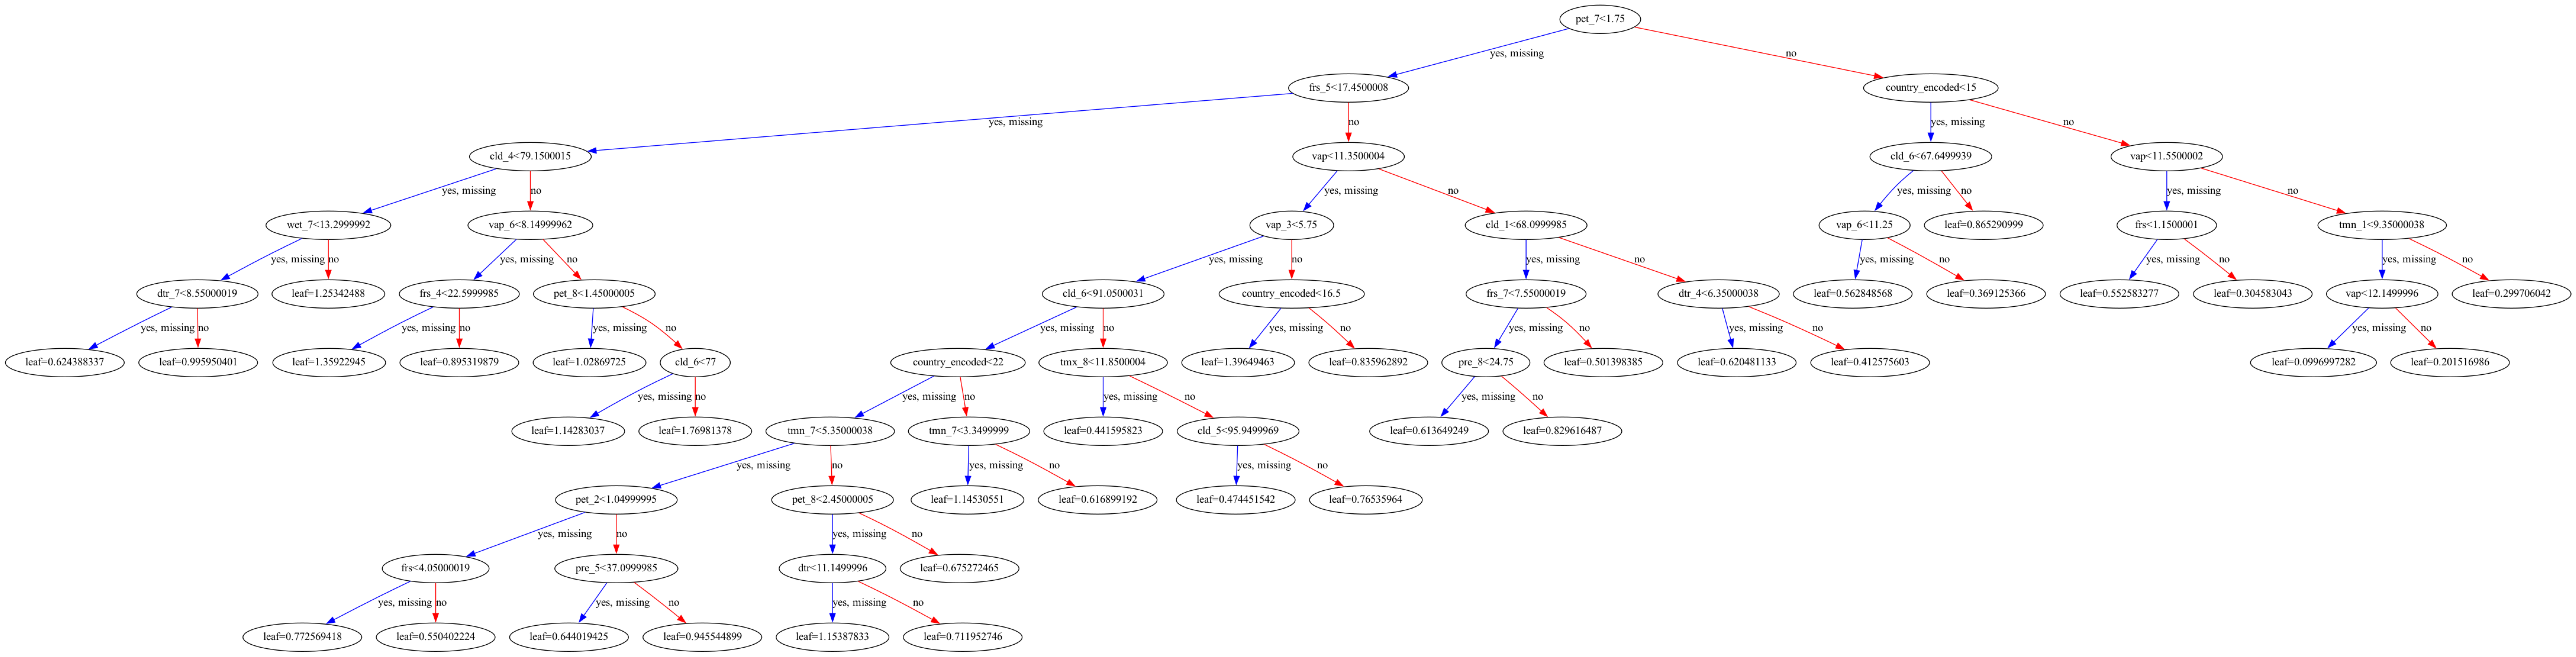

<Figure size 15000x15000 with 0 Axes>

In [340]:
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 150,150

plot_tree(xgd_model_hpt)
plt.figure(figsize=(150,150)) 
plt.show()